In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Importing Libraries
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd
import datetime 
import time 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
import math
import pickle
import os
import xgboost as xgb
import networkx as nx
import pdb
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm
from scipy.sparse.linalg import svds, eigs
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [ ]:
if os.path.isfile('/content/drive/MyDrive/Facebook/data/after_eda/train_pos_after_eda.csv'):
    train_graph=nx.read_edgelist('/content/drive/MyDrive/Facebook/data/after_eda/train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    print(nx.info(train_graph))
else:
    print("please run the FB_EDA.ipynb or download the files from drive")

Name: 
Type: DiGraph
Number of nodes: 1780722
Number of edges: 7550015
Average in degree:   4.2399
Average out degree:   4.2399


Read all final features created after EDA

In [ ]:
from pandas import read_hdf
df_final_train = read_hdf('/content/drive/MyDrive/Facebook/data/fea_sample/storage_sample_stage4.h5', 'train_df',mode='r')
df_final_test = read_hdf('/content/drive/MyDrive/Facebook/data/fea_sample/storage_sample_stage4.h5', 'test_df',mode='r')

In [ ]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6'],
      dtype='object')

# New Features

New Feature: Preferential Attachment with followers


In [ ]:
def preferential_attachment_followers(a,b):
  try:
    return len(set(train_graph.predecessors(a)))*len(set(train_graph.predecessors(b)))
  except:
    return 0

In [ ]:
preferential_attachment_followers(32,524)

22

New Feature: Preferential Attachment with followees

In [ ]:
def preferential_attachment_followees(a,b):
  try:
    return len(set(train_graph.successors(a)))*len(set(train_graph.successors(b)))
  except:
    return 0

In [ ]:
preferential_attachment_followees(32,524)

15

In [ ]:
df_final_train['preferential_attachment_followers']=\
df_final_train.apply(lambda p:preferential_attachment_followers(p['source_node'],p['destination_node']),axis=1)

df_final_train['preferential_attachment_followees']=\
df_final_train.apply(lambda p:preferential_attachment_followees(p['source_node'],p['destination_node']),axis=1)

df_final_test['preferential_attachment_followers']=\
df_final_test.apply(lambda p:preferential_attachment_followers(p['source_node'],p['destination_node']),axis=1)

df_final_test['preferential_attachment_followees']=\
df_final_test.apply(lambda p:preferential_attachment_followees(p['source_node'],p['destination_node']),axis=1)

In [ ]:
df_final_train.head(2)

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,inter_followers,inter_followees,adar_index,follows_back,same_comp,shortest_path,weight_in,weight_out,weight_f1,weight_f2,weight_f3,weight_f4,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d,svd_u_s_1,svd_u_s_2,svd_u_s_3,svd_u_s_4,svd_u_s_5,svd_u_s_6,svd_u_d_1,svd_u_d_2,svd_u_d_3,svd_u_d_4,svd_u_d_5,svd_u_d_6,svd_v_s_1,svd_v_s_2,svd_v_s_3,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,preferential_attachment_followers,preferential_attachment_followees
0,273084,1505602,1,0,0.000000,0.000000,0.000000,6,15,8,0,0,0.000000,0,1,4,0.377964,0.250,0.627964,0.094491,1.005929,0.877964,2.045290e-06,3.459963e-07,0.000773,0.000756,1.943132e-13,1.941103e-13,9.226339e-16,2.231877e-15,-1.666226e-13,4.613397e-13,1.043044e-05,6.676960e-13,2.451081e-13,3.584580e-12,-2.038017e-11,5.397495e-13,1.068946e-06,1.192357e-12,2.279485e-12,3.580837e-12,-7.216133e-13,3.925975e-13,1.983691e-06,1.545075e-13,8.108434e-13,1.719702e-14,-1.355368e-12,4.675307e-13,1.128591e-06,6.616550e-14,9.771077e-13,4.159752e-14,66,120
1,832016,1543415,1,0,0.187135,0.028382,0.343828,94,61,142,11,32,16.362912,0,1,2,0.102598,0.127,0.229598,0.013030,0.332196,0.356598,2.353458e-07,6.427660e-07,0.000845,0.001317,3.906648e-11,9.424102e-11,1.208074e-11,1.273080e-10,7.051088e-13,-8.250564e-11,-1.717702e-10,3.705016e-02,1.032392e-11,7.207497e-10,1.644399e-12,-2.047752e-10,-3.943936e-10,8.617541e-02,2.399540e-11,1.738682e-09,2.685878e-13,-3.316849e-11,-6.236048e-11,1.345726e-02,3.703479e-12,2.251737e-10,1.245101e-12,-1.636948e-10,-3.112650e-10,6.738902e-02,2.607801e-11,2.372904e-09,1598,8662


Adding svd_dot feature

In [ ]:
df_final_train['svd_dot_f1']=df_final_train['svd_u_s_1']*df_final_train['svd_u_d_1']+df_final_train['svd_u_s_2']*df_final_train['svd_u_d_2']+\
df_final_train['svd_u_s_3']*df_final_train['svd_u_d_3']+df_final_train['svd_u_s_4']*df_final_train['svd_u_d_4']+\
df_final_train['svd_u_s_5']*df_final_train['svd_u_d_5']+df_final_train['svd_u_s_6']*df_final_train['svd_u_d_6']

df_final_train['svd_dot_f2']=df_final_train['svd_v_s_1']*df_final_train['svd_v_d_1']+df_final_train['svd_v_s_2']*df_final_train['svd_v_d_2']+\
df_final_train['svd_v_s_3']*df_final_train['svd_v_d_3']+df_final_train['svd_v_s_4']*df_final_train['svd_v_d_4']+\
df_final_train['svd_v_s_5']*df_final_train['svd_v_d_5']+df_final_train['svd_v_s_6']*df_final_train['svd_v_d_6']

df_final_test['svd_dot_f1']=df_final_test['svd_u_s_1']*df_final_test['svd_u_d_1']+df_final_test['svd_u_s_2']*df_final_test['svd_u_d_2']+\
df_final_test['svd_u_s_3']*df_final_test['svd_u_d_3']+df_final_test['svd_u_s_4']*df_final_test['svd_u_d_4']+\
df_final_test['svd_u_s_5']*df_final_test['svd_u_d_5']+df_final_test['svd_u_s_6']*df_final_test['svd_u_d_6']

df_final_test['svd_dot_f2']=df_final_test['svd_v_s_1']*df_final_test['svd_v_d_1']+df_final_test['svd_v_s_2']*df_final_test['svd_v_d_2']+\
df_final_test['svd_v_s_3']*df_final_test['svd_v_d_3']+df_final_test['svd_v_s_4']*df_final_test['svd_v_d_4']+\
df_final_test['svd_v_s_5']*df_final_test['svd_v_d_5']+df_final_test['svd_v_s_6']*df_final_test['svd_v_d_6']

In [ ]:
df_final_train.head(2)

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,inter_followers,inter_followees,adar_index,follows_back,same_comp,shortest_path,weight_in,weight_out,weight_f1,weight_f2,weight_f3,weight_f4,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d,svd_u_s_1,svd_u_s_2,svd_u_s_3,svd_u_s_4,svd_u_s_5,svd_u_s_6,svd_u_d_1,svd_u_d_2,svd_u_d_3,svd_u_d_4,svd_u_d_5,svd_u_d_6,svd_v_s_1,svd_v_s_2,svd_v_s_3,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,preferential_attachment_followers,preferential_attachment_followees,svd_dot_f1,svd_dot_f2
0,273084,1505602,1,0,0.000000,0.000000,0.000000,6,15,8,0,0,0.000000,0,1,4,0.377964,0.250,0.627964,0.094491,1.005929,0.877964,2.045290e-06,3.459963e-07,0.000773,0.000756,1.943132e-13,1.941103e-13,9.226339e-16,2.231877e-15,-1.666226e-13,4.613397e-13,1.043044e-05,6.676960e-13,2.451081e-13,3.584580e-12,-2.038017e-11,5.397495e-13,1.068946e-06,1.192357e-12,2.279485e-12,3.580837e-12,-7.216133e-13,3.925975e-13,1.983691e-06,1.545075e-13,8.108434e-13,1.719702e-14,-1.355368e-12,4.675307e-13,1.128591e-06,6.616550e-14,9.771077e-13,4.159752e-14,66,120,1.114958e-11,2.238775e-12
1,832016,1543415,1,0,0.187135,0.028382,0.343828,94,61,142,11,32,16.362912,0,1,2,0.102598,0.127,0.229598,0.013030,0.332196,0.356598,2.353458e-07,6.427660e-07,0.000845,0.001317,3.906648e-11,9.424102e-11,1.208074e-11,1.273080e-10,7.051088e-13,-8.250564e-11,-1.717702e-10,3.705016e-02,1.032392e-11,7.207497e-10,1.644399e-12,-2.047752e-10,-3.943936e-10,8.617541e-02,2.399540e-11,1.738682e-09,2.685878e-13,-3.316849e-11,-6.236048e-11,1.345726e-02,3.703479e-12,2.251737e-10,1.245101e-12,-1.636948e-10,-3.112650e-10,6.738902e-02,2.607801e-11,2.372904e-09,1598,8662,3.192812e-03,9.068719e-04


In [ ]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6',
       'preferential_attachment_followers',
       'preferential_attachment_followees', 'svd_dot_f1', 'svd_dot_f2'],
      dtype='o

In [ ]:
y_train=df_final_train['indicator_link']
y_test=df_final_test['indicator_link']

In [ ]:
df_final_train.drop(['source_node','destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node','destination_node','indicator_link'],axis=1,inplace=True)

# Building Model 

# XGBOOST

# of Estimators =  10 Train Score 0.9210492696844526 test Score 0.9162413689582708
# of Estimators =  50 Train Score 0.9675354922332259 test Score 0.9231354642313546
# of Estimators =  100 Train Score 0.9736268857840504 test Score 0.9281594571670908
# of Estimators =  250 Train Score 0.9779501631263698 test Score 0.9152513258755074
# of Estimators =  500 Train Score 0.9830617711627158 test Score 0.8976821336592605
# of Estimators =  1000 Train Score 0.9910263994305022 test Score 0.8862563423781161


Text(0.5, 1.0, '# of Estimator vs score')

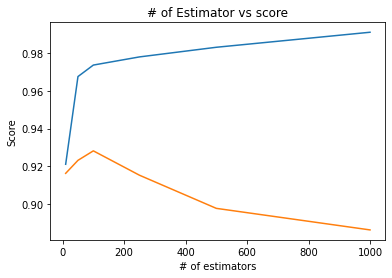

In [ ]:
from xgboost import XGBClassifier

estimators=[10,50,100,250,500,1000]
train_scores=[]
test_scores=[]

for i in estimators:
  clf1=XGBClassifier(n_estimators=i,booster='gbtree',n_jobs=-1,random_state=42)
  clf1.fit(df_final_train,y_train)
  train_sc=f1_score(y_train,clf1.predict(df_final_train))
  test_sc=f1_score(y_test,clf1.predict(df_final_test))
  train_scores+=train_sc,
  test_scores+=test_sc,
  print('# of Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('# of estimators')
plt.ylabel('Score')
plt.title('# of Estimator vs score')

Max_depth =  1 Train Score 0.9272776765709739 test Score 0.9170261354986045
Max_depth =  3 Train Score 0.9741812581063554 test Score 0.928221340518979
Max_depth =  5 Train Score 0.9780742987111447 test Score 0.9292449831535674
Max_depth =  10 Train Score 0.9932154398924106 test Score 0.9279361507928084
Max_depth =  20 Train Score 1.0 test Score 0.929061203758571
Max_depth =  50 Train Score 1.0 test Score 0.9301882800930823
Max_depth =  100 Train Score 1.0 test Score 0.9301882800930823
Max_depth =  200 Train Score 1.0 test Score 0.9301882800930823


Text(0.5, 1.0, 'Max_depth vs score')

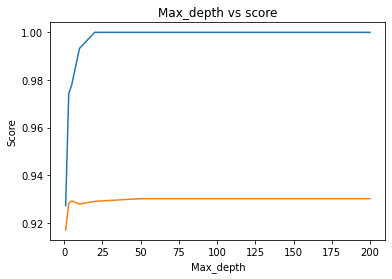

In [ ]:
from xgboost import XGBClassifier

depth=[1,3,5,10,20,50,100,200]
train_scores=[]
test_scores=[]

for i in depth:
  clf1=XGBClassifier(max_depth=i,n_estimators=115,booster='gbtree',n_jobs=-1,random_state=42)
  clf1.fit(df_final_train,y_train)
  train_sc=f1_score(y_train,clf1.predict(df_final_train))
  test_sc=f1_score(y_test,clf1.predict(df_final_test))
  train_scores+=train_sc,
  test_scores+=test_sc,
  print('Max_depth = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(depth,train_scores,label='Train Score')
plt.plot(depth,test_scores,label='Test Score')
plt.xlabel('Max_depth')
plt.ylabel('Score')
plt.title('Max_depth vs score')

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint,uniform
import random

parameters={"n_estimators":randint(100,125),
            "max_depth":randint(20,50)}

clf1=XGBClassifier(n_jobs=-1,random_state=42,booster='gbtree')
rs=RandomizedSearchCV(clf1,param_distributions=parameters,n_iter=5,cv=5,scoring='f1',random_state=42,return_train_score=True)
rs.fit(df_final_train,y_train)

print('mean train scores',rs.cv_results_['mean_train_score'])
print('mean test scores',rs.cv_results_['mean_test_score'])

mean train scores [1. 1. 1. 1. 1.]
mean test scores [0.9791718  0.9788873  0.97916364 0.97905148 0.97914101]


In [ ]:
print(rs.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=26,
              min_child_weight=1, missing=None, n_estimators=119, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


In [ ]:
clf1=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=26,
              min_child_weight=1, missing=None, n_estimators=119, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
clf1.fit(df_final_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=26,
              min_child_weight=1, missing=None, n_estimators=119, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
y_train_pred=clf1.predict(df_final_train)
y_test_pred=clf1.predict(df_final_test)

In [ ]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 1.0
Test f1 score 0.9290931803264805


In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    labels = [0,1]
    
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


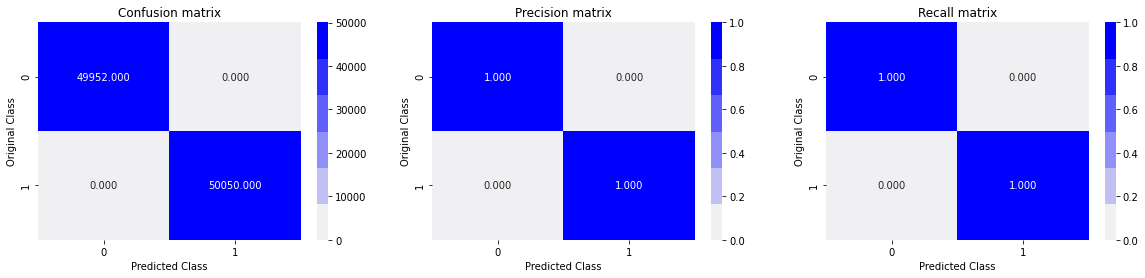

Test confusion_matrix


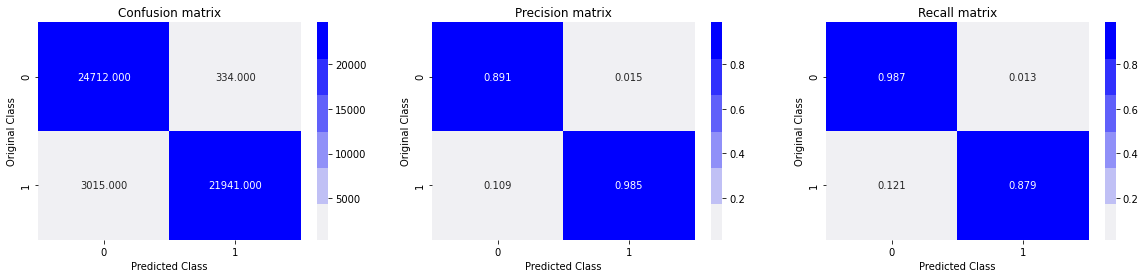

In [ ]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

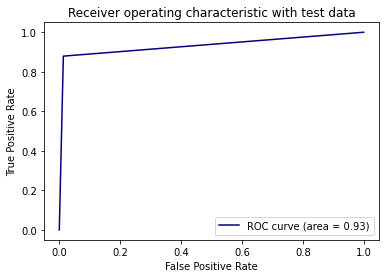

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

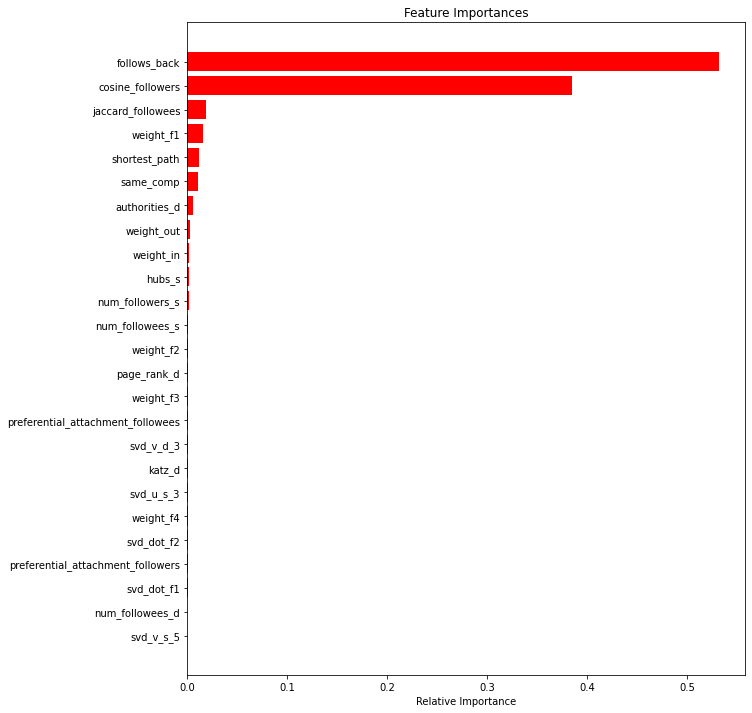

In [ ]:
features = df_final_train.columns
importances = clf1.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Findings:

1. Using XGBOOST Classifiers,most important features are follows_back, cosine followers, jaccard followees, weight_f1,shortest path, same component,authority.

2. Preferential attachment and svd dot doesn't account much more feature value.

3. Slightly increase in class 1 precision value and class 0 recall value using XGBOOST as compare to previous Random forest classifier.


# Random forest

# of Estimators =  10 Train Score 0.9625515612806455 test Score 0.8852987987005908
# of Estimators =  50 Train Score 0.9629486841304303 test Score 0.9228757618575617
# of Estimators =  100 Train Score 0.9635091277890466 test Score 0.9219792282360888
# of Estimators =  250 Train Score 0.9639756592292089 test Score 0.9238199687855907
# of Estimators =  500 Train Score 0.9637173258137482 test Score 0.9244228944871928
# of Estimators =  1000 Train Score 0.9636409762037648 test Score 0.9237779793675238


Text(0.5, 1.0, '# of Estimator vs score')

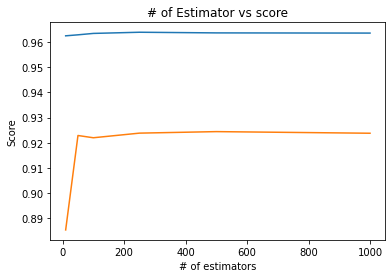

In [ ]:
from sklearn.ensemble import RandomForestClassifier

estimators=[10,50,100,250,500,1000]
train_scores=[]
test_scores=[]

for i in estimators:
  clf2=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=i, n_jobs=-1,random_state=42,verbose=0,warm_start=False)
  clf2.fit(df_final_train,y_train)
  train_sc=f1_score(y_train,clf2.predict(df_final_train))
  test_sc=f1_score(y_test,clf2.predict(df_final_test))
  train_scores+=train_sc,
  test_scores+=test_sc,
  print('# of Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('# of estimators')
plt.ylabel('Score')
plt.title('# of Estimator vs score')

Max_depth =  1 Train Score 0.8229730296547964 test Score 0.8007953646490347
Max_depth =  3 Train Score 0.8738972385791118 test Score 0.8590442142441799
Max_depth =  5 Train Score 0.9215298901397555 test Score 0.9139984011444439
Max_depth =  10 Train Score 0.9600569597721609 test Score 0.9243467458362284
Max_depth =  15 Train Score 0.9630365579188547 test Score 0.9236956247104897
Max_depth =  20 Train Score 0.9636995813439568 test Score 0.9262388097339553
Max_depth =  35 Train Score 0.9637454884626302 test Score 0.9238644981882531
Max_depth =  50 Train Score 0.9637454884626302 test Score 0.9238644981882531
Max_depth =  100 Train Score 0.9637454884626302 test Score 0.9238644981882531


Text(0.5, 1.0, 'Max_depth vs score')

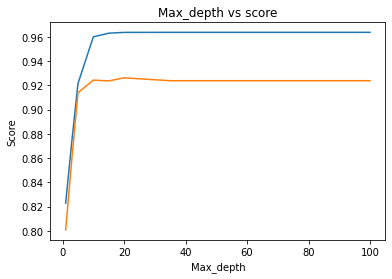

In [ ]:
depth=[1,3,5,10,15,20,35,50,100]
train_scores=[]
test_scores=[]

for i in depth:
  clf2=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=i, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
  clf2.fit(df_final_train,y_train)
  train_sc=f1_score(y_train,clf2.predict(df_final_train))
  test_sc=f1_score(y_test,clf2.predict(df_final_test))
  train_scores+=train_sc,
  test_scores+=test_sc,
  print('Max_depth = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(depth,train_scores,label='Train Score')
plt.plot(depth,test_scores,label='Test Score')
plt.xlabel('Max_depth')
plt.ylabel('Score')
plt.title('Max_depth vs score')

In [ ]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

param_dist = {"n_estimators":sp_randint(475,525),
              "max_depth": sp_randint(15,25),
              "min_samples_split": sp_randint(110,190),
              "min_samples_leaf": sp_randint(25,65)}

clf2=RandomForestClassifier(random_state=42,n_jobs=-1)

rs=RandomizedSearchCV(clf2,param_distributions=param_dist,n_iter=5,cv=5,scoring='f1',random_state=42,return_train_score=True)

rs.fit(df_final_train,y_train)

print('mean test scores',rs.cv_results_['mean_test_score'])
print('mean train scores',rs.cv_results_['mean_train_score'])

mean test scores [0.96216223 0.96210683 0.96204799 0.96335849 0.96223864]
mean train scores [0.9630464  0.96285619 0.96255618 0.96454871 0.96293742]


In [77]:
print(rs.best_estimator_)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=26, min_samples_split=139,
                       min_weight_fraction_leaf=0.0, n_estimators=512,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)


In [79]:
clf2=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=26, min_samples_split=139,
                       min_weight_fraction_leaf=0.0, n_estimators=512,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [80]:
clf2.fit(df_final_train,y_train)
y_train_pred=clf2.predict(df_final_train)
y_test_pred=clf2.predict(df_final_test)

In [81]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9654291449542773
Test f1 score 0.9244566364211859


Train confusion_matrix


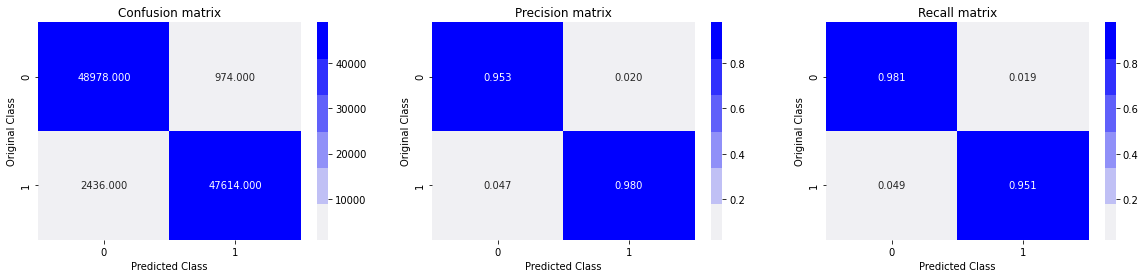

Test confusion_matrix


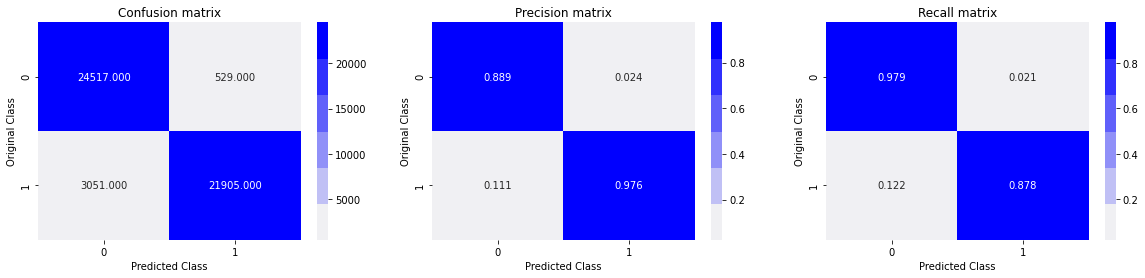

In [82]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

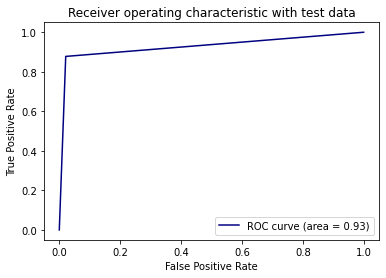

In [83]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

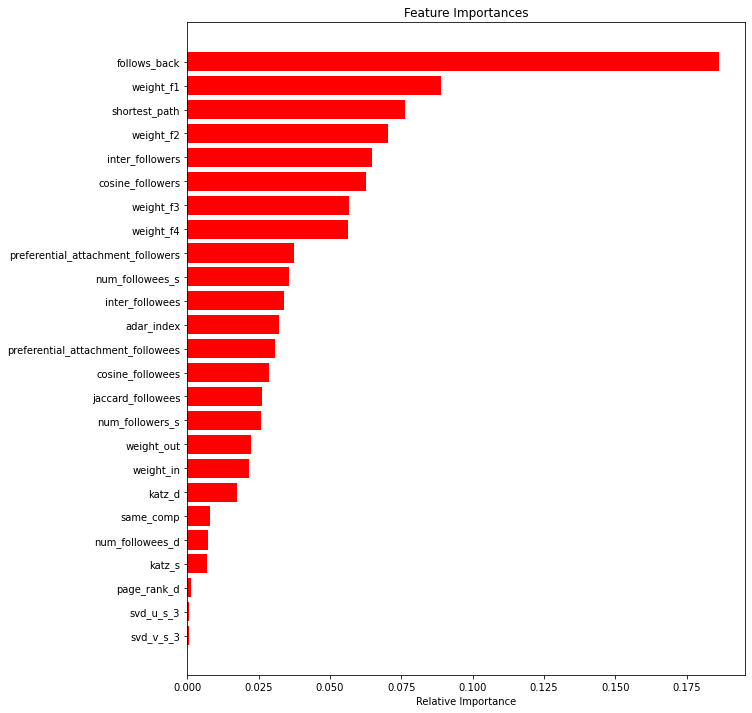

In [84]:
features = df_final_train.columns
importances = clf2.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Findings:

1. Newly added Preferential attachment followers and followees are the important features while using random forest.

2. Newly added svd_dot is not present in top 25 features.

3. Slide increase in class 1 precision and recall values using new features.